# Interview project created by Kranio
## César Ramírez ramirez.u@gmail.com

**Problem description**
Imagine we work for a movie studio companny, and we're trying to decide what will be our next great production. For that, you should do some analytics based on past releases database found on kaggle movies dataset and present them for executives of the companny.
The analysis should be achieved through a small pipeline with two phases, transformation and load, transformation should be done with PySpark (metrics will be described bellow), and for the second phase, you should load the transformed data with Pandas and show their results with any charts library of your choice, some examples are: plotly, matplotlib or seaborn.

The final report should present the following metrics:
- Most profitable movies by semester.
- Most profitable genres by year.
- Top 10 profitable movies by genres (maximum of 5 genres).
- Movies popularity by month (to know the best release date).
- Total of releases for each genre for the last 5 years.

**Requirements & Observations**
- You can create the solution with Jupyter Notebooks if you preffer. Add a a description how to test your solution.
- Always try to follow the most the best practices and clean code, you can use PyLint to check this.
- The metrics should be stored as Parquet format for better read speed.
- Solution running on Docker containers would be desirable.
- Orchestrate the pipeline with Airflow would be desirable.
- Achieve what you can, don't be afraid of change the requirements if there is some tecnology you don't manage so well. **Good luck and Have Fun!**

This next code block does the following:

 1. It imports the necessary classes and functions from the pyspark.sql
    module.
 2. It creates a SparkSession object and loads a CSV file into a
    dataframe.
 3. It adds a new column to the dataframe called "profit" by subtracting the "budget" column from the "revenue" column.
 4. It drops unnecesary columns from the dataframe.
 5. It prints the schema of the dataframe to the console.

The resulting dataframe will contain the columns specified in step 4 and the new "profit" column, and will not contain the dropped columns. The schema of the dataframe will be printed to the console, which will show the names and data types of all the columns in the dataframe.

The next code block retrieves a file called "movies.csv" from a remote server using the wget command and stores it on the local machine. wget is a command-line utility for downloading files from the web. The file is located at the specified URL, which in this case is "https://storage.googleapis.com/kranio-2f26b74d-9cae-4ac7-ab11-89e2a454eb83/movies.csv".

The .csv file extension indicates that the file is a comma-separated values file, which is a type of text file that stores tabular data. The data is typically organized into rows and columns, with each row representing a record and each column representing a field or attribute of the record. In this case, the file likely contains information about movies, such as their titles, release dates, and cast members.

In [1]:
!wget https://storage.googleapis.com/kranio-2f26b74d-9cae-4ac7-ab11-89e2a454eb83/movies.csv

--2022-12-21 22:15:08--  https://storage.googleapis.com/kranio-2f26b74d-9cae-4ac7-ab11-89e2a454eb83/movies.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.192.128, 142.250.0.128, 142.251.0.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.192.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 354132446 (338M) [text/csv]
Saving to: ‘movies.csv.1’

movies.csv.1        100%[===================>] 337.73M  1.91MB/s    in 89s     

2022-12-21 22:16:38 (3.78 MB/s) - ‘movies.csv.1’ saved [354132446/354132446]



In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql import Window

spark = SparkSession.builder.appName("MyApp").getOrCreate()

df = spark.read.format("csv").option("header", "true").load("movies.csv")

df = df.withColumn("profit", df.revenue -  df.budget)

df = df.drop("original_language", "overview", "production_companies", "runtime", "status", "tagline", "vote_average", "credits", "keywords", "poster_path", "backdrop_path", "recommendations", "vote_count", "revenue", "budget")
             
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- profit: double (nullable = true)



This next code block does the following:

 1. It adds a new column to the dataframe called
    "timestamp_release_date" by converting the "release_date" column to a timestamp using the format "yyyy-MM-dd".
 2. It adds two new columns to the dataframe called "month" and "year" by extracting the month and year from the "timestamp_release_date" column.
 3. It adds a new column called "semester" to the dataframe. The value of this column is determined by the value of the "month" column: if the month is less than or equal to 6, the value of the "semester" column will be the year followed by " - 1st Semester". If the month is greater than or equal to 7, the value of the "semester" column will be the year followed by " - 2nd Semester".
 4. It drops unnecesary columns from the dataframe.
 5. It groups the data by the "semester" column and calculates the
    maximum value of the "profit" column for each group. The resulting
    data is stored in a new dataframe called "df1grouped".
 6. It performs a join between the original dataframe and the grouped
    dataframe on the "profit" and "semester" columns. The resulting data is stored in a new dataframe called "df_most_profitablebs".
 7. It selects specific columns from the "df_most_profitablebs"
    dataframe and sorts the rows in descending order by the "semester" column. The resulting data is stored in a new dataframe called "df1".
 8. It displays the contents of the "df1" dataframe to the console.

The resulting dataframe will contain the "semester", "id", "title", and "profit" columns and will be sorted by the "semester" column in descending order. The "semester" column will contain values indicating the year and semester for each row, and the "profit" column will contain the maximum profit for each semester.

In [11]:
# Most profitable movies by semester.

df1 = df.withColumn("timestamp_release_date", to_timestamp("release_date", "yyyy-MM-dd"))

df1 = df1.withColumn("month", month("timestamp_release_date"))
df1 = df1.withColumn("year", year("timestamp_release_date"))

df1 = df1.withColumn("semester", when(col("month") <= 6, concat(col("year"),lit(" - 1st Semester"))).when(col("month") >= 7, concat(col("year"),lit(" - 2nd Semester"))))

df1 = df1.drop("genres", "popularity", "release_date", "timestamp_release_date", "month", "year")

df1grouped = df1.groupBy("semester").agg(max("profit").alias("max_profit"))

df_most_profitablebs = df1.join(df1grouped, (df1.profit == df1grouped.max_profit) & (df1.semester == df1grouped.semester)).drop(df1.semester)

df1 = df_most_profitablebs.select("semester", "id", "title", df_most_profitablebs.max_profit.alias("profit")).sort("profit", ascending=False).limit(100)
df1.show()


+-------------------+------+--------------------+-------------+
|           semester|    id|               title|       profit|
+-------------------+------+--------------------+-------------+
|2009 - 2nd Semester| 19995|              Avatar|2.683357254E9|
|2019 - 1st Semester|299534|   Avengers: Endgame|2.441800564E9|
|1997 - 2nd Semester|   597|             Titanic|1.987463944E9|
|2015 - 2nd Semester|140607|Star Wars: The Fo...|1.823223624E9|
|2018 - 1st Semester|299536|Avengers: Infinit...|1.746239637E9|
|2021 - 2nd Semester|634649|Spider-Man: No Wa...|1.716306995E9|
|2015 - 1st Semester|135397|      Jurassic World|1.521713208E9|
|2019 - 2nd Semester|420818|       The Lion King|1.407635327E9|
|2022 - 1st Semester|361743|   Top Gun: Maverick|      1.318E9|
|2012 - 1st Semester| 24428|        The Avengers|1.298815515E9|
|2011 - 2nd Semester| 12445|Harry Potter and ...|1.216511219E9|
|2023 - 2nd Semester|935355|     Parallel Heroes|     1.1891E9|
|2017 - 2nd Semester|181808|Star Wars: T

The next block code does the following:

1.  It groups the data in the "df" dataframe by the year extracted from the "release_date" column and calculates the maximum value of the "profit" column for each group. The resulting data is stored in a new dataframe called "df2".
2.  It performs a join between the original dataframe and the grouped dataframe on the "profit" and "year" columns. The resulting data is stored in a new dataframe called "df_most_profitable".
3.  It selects specific columns from the "df_most_profitable" dataframe and sorts the rows in descending order by the "year" column. It also filters the rows to include only those with a positive value in the "profit" column and a non-null value in the "profit" column. The resulting data is stored in a new dataframe called "df2".
4.  It displays the contents of the "df2" dataframe to the console.

The resulting dataframe will contain the "id", "title", "year", and "profit" columns and will be sorted by the "year" column in descending order. The "year" column will contain the year extracted from the "release_date" column, and the "profit" column will contain the maximum profit for each year. The rows will be filtered to include only those with a positive value in the "profit" column and a non-null value in the "profit" column.

In [12]:
# Most profitable movies by year.

df2 = df.groupBy(year("release_date").alias("year")).agg(max("profit").alias("max_profit"))
df_most_profitable = df.join(df2, (df.profit == df2.max_profit) & (year("release_date") == df2.year))
df2 = df_most_profitable.select("id", "title", "year", df_most_profitable.max_profit.alias("profit"))\
    .sort("year", ascending=False)\
    .filter(df_most_profitable.profit > 0)\
    .filter(df_most_profitable.profit.isNotNull()).limit(100)
df2.show()

+------+--------------------+----+-------------+
|    id|               title|year|       profit|
+------+--------------------+----+-------------+
|939020|     Narayan Pustika|2024|      43651.0|
|935355|     Parallel Heroes|2023|     1.1891E9|
|361743|   Top Gun: Maverick|2022|      1.318E9|
|634649|Spider-Man: No Wa...|2021|1.716306995E9|
|635302|Demon Slayer -Kim...|2020| 4.87263688E8|
|299534|   Avengers: Endgame|2019|2.441800564E9|
|299536|Avengers: Infinit...|2018|1.746239637E9|
|181808|Star Wars: The La...|2017| 1.13269883E9|
|271110|Captain America: ...|2016| 9.03337496E8|
|140607|Star Wars: The Fo...|2015|1.823223624E9|
| 91314|Transformers: Age...|2014| 8.94054072E8|
|109445|              Frozen|2013|1.124219009E9|
| 24428|        The Avengers|2012|1.298815515E9|
| 12445|Harry Potter and ...|2011|1.216511219E9|
| 10193|         Toy Story 3|2010| 8.66969703E8|
| 19995|              Avatar|2009|2.683357254E9|
|   155|     The Dark Knight|2008| 8.19558444E8|
|   675|Harry Potter

The next code block does the following:

1.  Copying the DataFrame to a new DataFrame called `df3`.
2.  Splitting the genres in the "genres" column by a hyphen (-) and creating a new column called "genre" by exploding the resulting list of genres.
3.  Removing unnecesary columns from `df3`.
4.  Grouping the rows of `df3` by the "genre" column, computing the sum of the "profit" column for each group, and renaming the sum as "total_profit". The resulting DataFrame is sorted in descending order by "total_profit" and limited to the top 5 rows.
5.  Joining the original `df3` DataFrame with the DataFrame created in the previous step on the "genre" column and sorting the resulting DataFrame in descending order by "profit".
6.  Removing the "total_profit" column.
7.  Sorting the DataFrame by "genre" and "profit" in descending order.
8.  Adding a new column called "rank" to the DataFrame that assigns a rank to each row within each "genre" group, based on the value of the "profit" column in descending order.
9.  Filtering the DataFrame to keep only the rows where the "rank" column is less than or equal to 10.
10.  Sorting the DataFrame by "rank" in ascending order.
11.  Overwriting the original `df3` DataFrame with the modified DataFrame.
12.  Displaying the contents of the final DataFrame.

In [13]:
#Top 10 profitable movies by genres (maximum of 5 genres).

df3 = df
df3a = df3.withColumn("genre", explode(split(df3.genres, "-")))
df3a = df3a.drop("genres", "popularity", "release_date")

df3b = df3a.groupBy("genre").agg(sum("profit").alias("total_profit")).sort(desc("total_profit")).limit(5)

df3a = df3a.join(df3b, on=["genre"], how="inner").sort(desc("profit"))
df3a = df3a.drop("total_profit")
df3a = df3a.sort("genre", "profit", ascending=False)


df3a = df3a.withColumn("rank", row_number().over(Window.partitionBy("genre").orderBy(desc("profit"))))
df3a = df3a.filter(df3a["rank"] <= 10)
df3a = df3a.sort("rank")
df3 = df3a
df3.show()

+---------+------+--------------------+-------------+----+
|    genre|    id|               title|       profit|rank|
+---------+------+--------------------+-------------+----+
|  Fantasy| 19995|              Avatar|2.683357254E9|   1|
|   Comedy|330457|           Frozen II|1.300026933E9|   1|
|    Drama|   597|             Titanic|1.987463944E9|   1|
|Adventure| 19995|              Avatar|2.683357254E9|   1|
|   Action| 19995|              Avatar|2.683357254E9|   1|
|Adventure|299534|   Avengers: Endgame|2.441800564E9|   2|
|   Action|299534|   Avengers: Endgame|2.441800564E9|   2|
|  Fantasy|140607|Star Wars: The Fo...|1.823223624E9|   2|
|   Comedy|211672|             Minions|1.082730962E9|   2|
|    Drama|420818|       The Lion King|1.407635327E9|   2|
|Adventure|140607|Star Wars: The Fo...|1.823223624E9|   3|
|  Fantasy|330457|           Frozen II|1.300026933E9|   3|
|   Action|140607|Star Wars: The Fo...|1.823223624E9|   3|
|   Comedy|324852|     Despicable Me 3| 9.51552585E8|   

The next code block does the following:

This code block is performing operations to identify the most popular movie in each month, based on the "popularity" column. It first converts the "release_date" column to a date data type and extracts the month from each date. It then groups the movies by month, calculates the maximum value of the "popularity" column for each group, and joins this information with the original DataFrame to identify the movie with the highest popularity in each month. Finally, it sorts the resulting DataFrame by month and displays it.

In [14]:
#Movies popularity by month (to know the best release date).

df4 = df
df4 = df4.withColumn("release_date", to_date(df4.release_date, "yyyy-MM-dd"))
df4 = df4.withColumn("month", month(df4.release_date))
df4 = df4.drop("genres", "profit", "release_date")
df4 = df4.withColumn("popularity", col("popularity").cast("float"))

most_popular_by_month = df4.groupBy("month").agg(max("popularity").alias("most_popular_popularity"))

df4 = most_popular_by_month.join(df4, (most_popular_by_month.month == df4.month) & (most_popular_by_month.most_popular_popularity == df4.popularity)).drop(most_popular_by_month.month)
df4 = df4.drop("most_popular_popularity").sort("month")
df4.show()

+------+--------------------+----------+-----+
|    id|               title|popularity|month|
+------+--------------------+----------+-----+
|928015|Dracula: The Orig...|   408.176|    1|
|667276|Legend Quest: The...|    804.96|    2|
|836225| The Exorcism of God|   480.532|    3|
|956101|   The Eighth Clause|  2259.303|    4|
|792775|          Cop Secret|  1137.861|    5|
|899294|  Frank and Penelope|  2128.548|    6|
|892070|Padre no hay más ...|   749.721|    7|
|629176|           Samaritan|   612.504|    8|
|724495|      The Woman King|  1982.618|    9|
|436270|          Black Adam|  3874.056|   10|
|555604|Guillermo del Tor...|  3298.712|   11|
| 76600|Avatar: The Way o...|  4650.217|   12|
+------+--------------------+----------+-----+



The next block code is performing operations to identify the number of movies in each genre that were released on or after January 1, 2017. It first filters the DataFrame to include only movies released on or after this date, then it splits the genres in the "genres" column by a hyphen (-) and creates a new column called "genre" by exploding the resulting list of genres. It then groups the movies by genre and counts the number of movies in each group. Finally, it sorts the resulting DataFrame in descending order by the count of movies in each genre and displays the results.

In [15]:
#Total of releases for each genre for the last 5 years.

df5 = df.filter(col("release_date") >= "2017-01-01")
df5 = df5.withColumn("genre", explode(split(df5.genres, "-")))
df5 = df5.groupBy("genre").count()
df5.orderBy("count", ascending=False).show()


+--------------------+-----+
|               genre|count|
+--------------------+-----+
|               Drama|45489|
|         Documentary|41581|
|              Comedy|25775|
|              Horror|12731|
|            Thriller|11987|
|           Animation|10869|
|             Romance|10184|
|               Music| 8566|
|              Action| 8034|
|               Crime| 5609|
|     Science Fiction| 5125|
|              Family| 4995|
|             Fantasy| 4922|
|             Mystery| 4515|
|            TV Movie| 4336|
|           Adventure| 3506|
|             History| 3328|
|                 War| 1258|
|             Western|  515|
| We're Comin' To ...|    1|
+--------------------+-----+
only showing top 20 rows



The next code block is using the write method of the DataFrame class in the PySpark library to save the contents of five DataFrames (df1, df2, df3, df4, and df5) to the file system in the Parquet file format. The format method specifies the file format as Parquet, and the mode method specifies that the existing files should be overwritten if they already exist. The save method specifies the location where the files should be saved, using the work directory as the base path and appending a unique file name for each DataFrame.

The import pandas as pd statement at the beginning of the code block is importing the pandas library, which is a popular library for working with data in Python.

In [16]:
import pandas as pd

df1.write.format("parquet").mode("overwrite").save("work/df1.parquet")
df2.write.format("parquet").mode("overwrite").save("work/df2.parquet")
df3.write.format("parquet").mode("overwrite").save("work/df3.parquet")
df4.write.format("parquet").mode("overwrite").save("work/df4.parquet")
df5.write.format("parquet").mode("overwrite").save("work/df5.parquet")


The next code block is using the read_parquet function of the pandas library to read the contents of five Parquet files (df1.parquet, df2.parquet, df3.parquet, df4.parquet, and df5.parquet) from the file system and store them as pandas DataFrames. The resulting DataFrames are stored in variables called pdf1, pdf2, pdf3, pdf4, and pdf5, respectively.

The read_parquet function is used to read a Parquet file into a pandas DataFrame. It takes a file path as its argument and returns a pandas DataFrame that contains the data from the file.

In [17]:
pdf1 = pd.read_parquet("work/df1.parquet")
pdf2 = pd.read_parquet("work/df2.parquet")
pdf3 = pd.read_parquet("work/df3.parquet")
pdf4 = pd.read_parquet("work/df4.parquet")
pdf5 = pd.read_parquet("work/df5.parquet")


The next code block appears to be using the seaborn and matplotlib libraries to create visualizations of the data in five pandas DataFrames (pdf1, pdf2, pdf3, pdf4, and pdf5). It is also using the print function to output text to the console.

The seaborn library is a popular library for creating statistical graphics in Python, and the matplotlib library is a widely used library for creating visualizations in Python.



The next code block does:

In order to show the “**Most profitable movies by semester**”, the code first subsets the pdf1 DataFrame to include only the "title", "semester", and "profit" columns. It then creates a figure with a specified size using the figure function. Next, it creates a table of the data in the pdf1 DataFrame using the table function, with the cell values taken from the values in pdf1, the column labels taken from the column names of pdf1, and the row labels taken from the index of pdf1. The x-axis and y-axis of the plot are then hidden using the tick_params function. The plot's spines (the lines around the edges) are hidden using a loop over the spines attribute of the current axis. The text "Most profitable movies by semester" is printed to the console using the print function, and the plot is displayed using the show function.

In order to show “**Most profitable movies by year**”, the code subsets the pdf2 DataFrame to include only the "title", "year", and "profit" columns. It then creates a figure with a specified size using the figure function. Next, it creates a table of the data in the pdf2 DataFrame using the table function, with the cell values taken from the values in pdf2, the column labels taken from the column names of pdf2, and the row labels taken from the index of pdf2. The x-axis and y-axis of the plot are then hidden using the tick_params function. The plot's spines (the lines around the edges) are hidden using a loop over the spines attribute of the current axis. The text "Most profitable movies by year" is printed to the console using the print function, and the plot is displayed using the show function.

In order to show “**Top 10 profitable movies by genres (maximum of 5 genres)**”, the code generates a bar plot that compares the profitability of the top 10 movies in a given dataset for up to five different genres. The plot has one bar for each movie, and the y-axis shows the movie's title. The x-axis shows the movie's rank, with rank 1 being the most profitable. The plot is generated using the sns.barplot function from the seaborn library, and it is displayed using the plt.show function from the matplotlib library. The input data for the plot is taken from the DataFrame pdf3, and the unique genres in the DataFrame are obtained using the unique method. The title column of the DataFrame is modified to show only the first 10 characters of each movie title, followed by an ellipsis if the title is longer than 10 characters. The plot is given a main title using the suptitle function.

In order to show “**Movies popularity by month**”, the code generates a bar plot that compares the popularity of movies in a given dataset across different months. The plot has one bar for each movie, and the y-axis shows the month and title of the movie. The x-axis shows the movie's popularity. The plot is generated using the sns.barplot function from the seaborn library, and it is displayed using the plt.show function from the matplotlib library. The input data for the plot is taken from the DataFrame pdf4. A new column called "month with title" is created in the DataFrame by concatenating the values in the "month" and "title" columns with some additional text. The "month" and "title" columns are first cast to strings using the astype method. The plot is given a title using the plt.title function.

In order to show “**Total of releases for each genre for the last 5 years**”, the code generates a bar plot that shows the total number of movie releases for each genre in a given dataset for the last five years. The plot has one bar for each genre, and the y-axis shows the genre. The x-axis shows the number of movie releases. The plot is generated using the sns.barplot function from the seaborn library, and it is displayed using the plt.show function from the matplotlib library. The input data for the plot is taken from the DataFrame pdf5, which have a column called "count" that represents the number of movie releases and a column called "genre" that represents the genre of the movies. The plot is given a title using the plt.title function.

Most profitable movies by semester


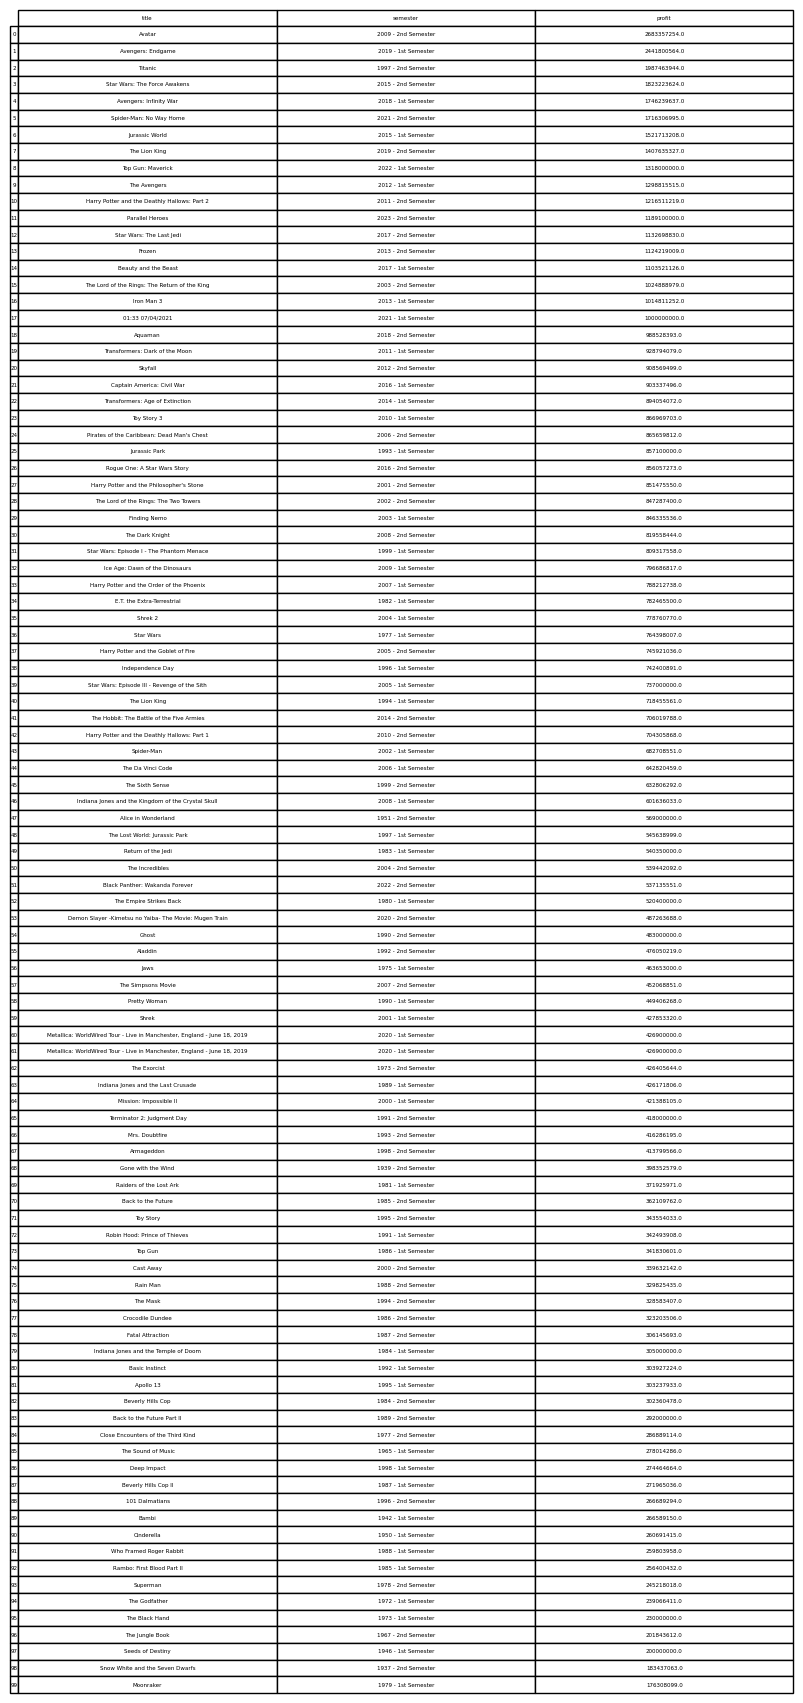

Most profitable movies by year


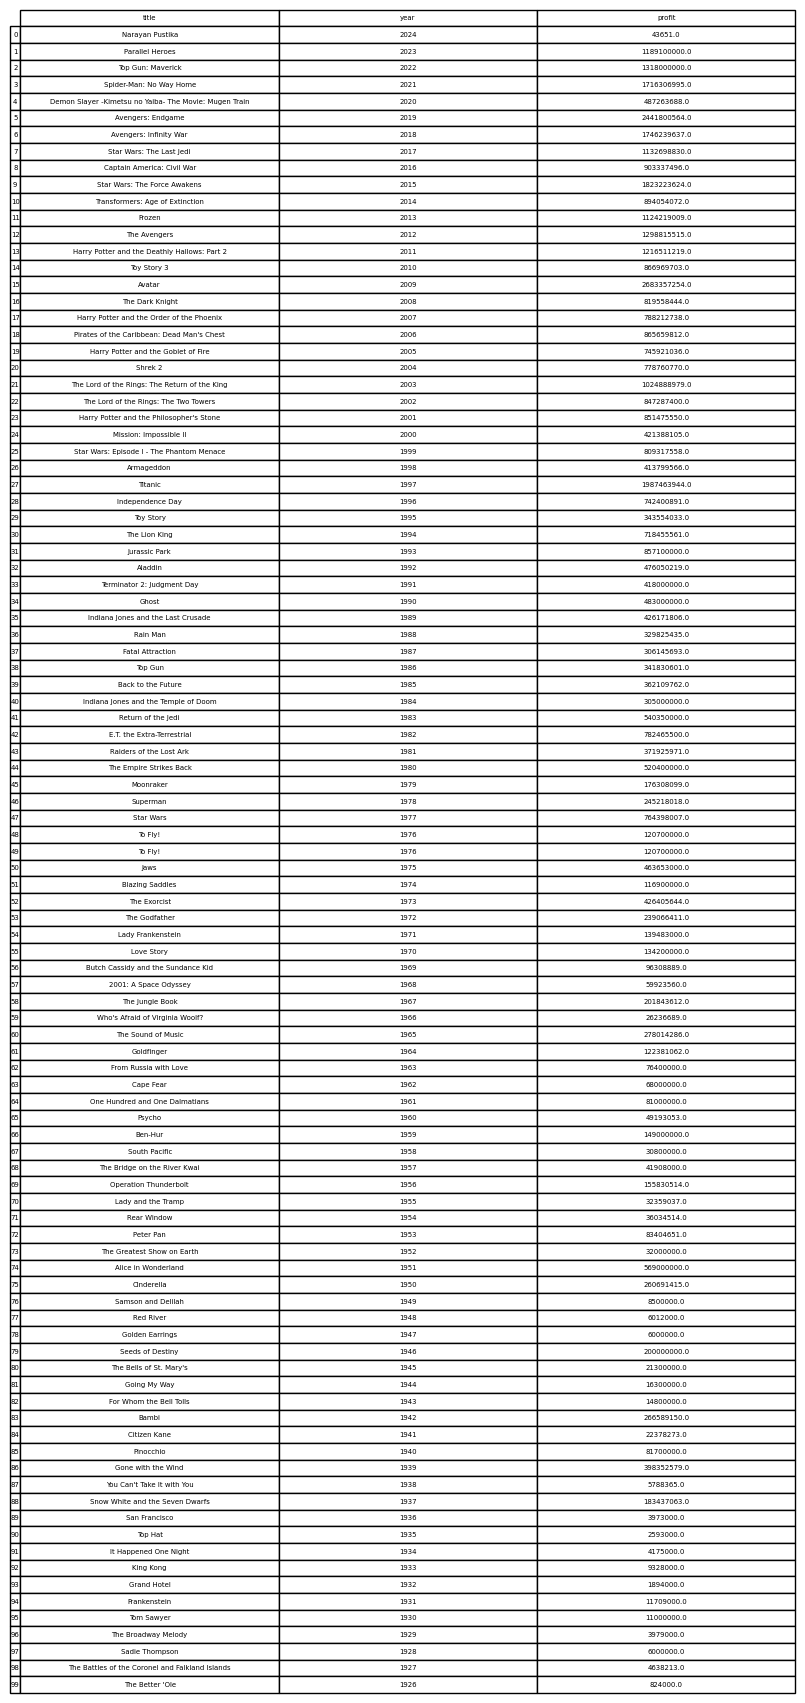

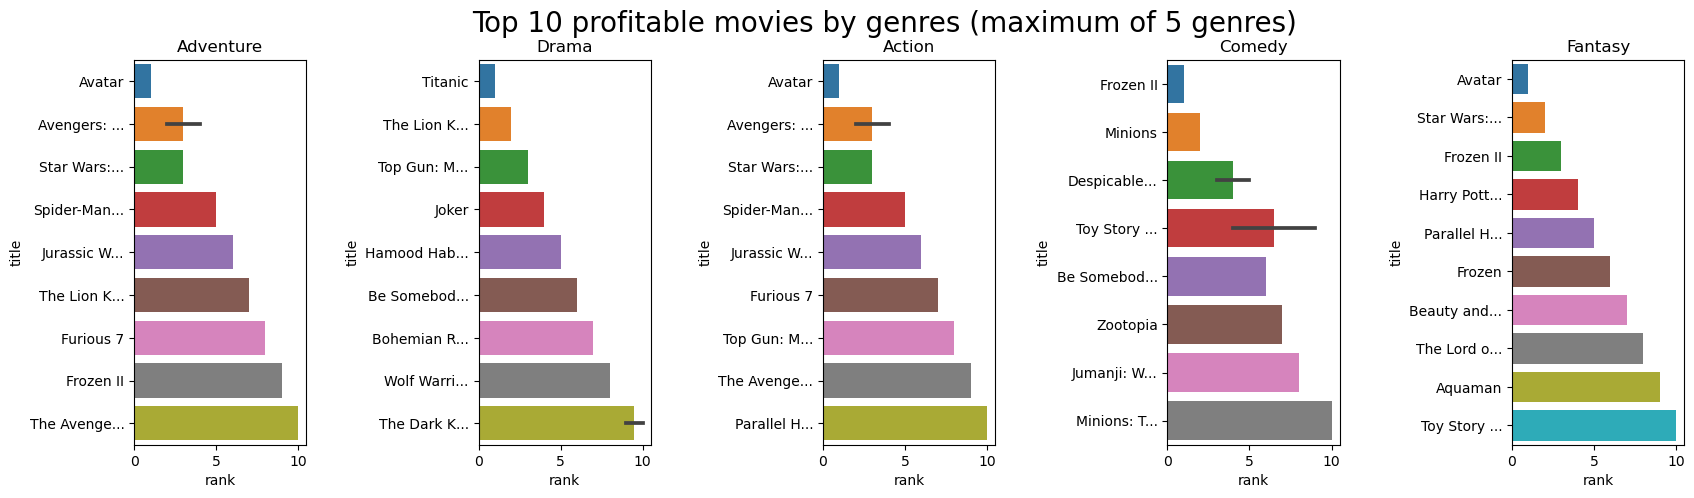

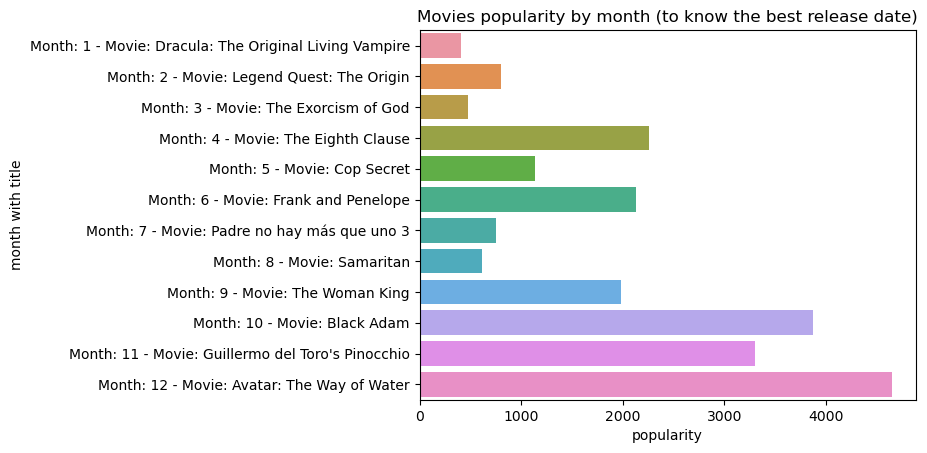

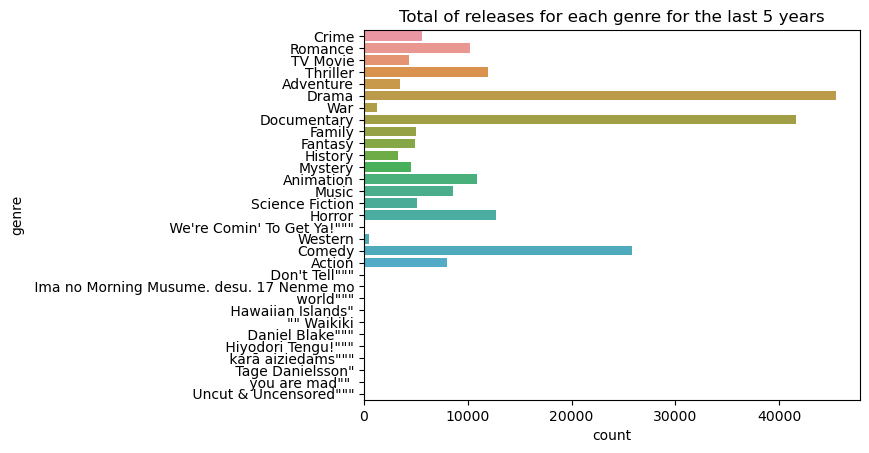

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

pdf1 = pdf1[['title', 'semester', 'profit']]
plt.figure(figsize=(10, 6))
plt.table(cellText=pdf1.values,
          colLabels=pdf1.columns,
          rowLabels=pdf1.index,
          cellLoc='center',
          rowLoc='center',
          loc='center')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
print("Most profitable movies by semester")
plt.show()

pdf2 = pdf2[['title', 'year', 'profit']]
plt.figure(figsize=(10, 6))
plt.table(cellText=pdf2.values,
          colLabels=pdf2.columns,
          rowLabels=pdf2.index,
          cellLoc='center',
          rowLoc='center',
          loc='center')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
print("Most profitable movies by year")
plt.show()

genres = pdf3['genre'].unique()
pdf3['title'] = pdf3['title'].apply(lambda x: x[:10] + '...' if len(x) > 10 else x)
fig, axs = plt.subplots(1, len(genres), figsize=(20, 5))
for i, genre in enumerate(genres):
    sns.barplot(x='rank', y='title', data=pdf3[pdf3['genre'] == genre], ax=axs[i])
    axs[i].set_title(genre)
fig.subplots_adjust(wspace=1)
fig.suptitle("Top 10 profitable movies by genres (maximum of 5 genres)", fontsize=20)
plt.show()

pdf4["month with title"] = "Month: "+pdf4["month"].astype(str) + " - Movie: " + pdf4["title"].astype(str)
sns.barplot(x="popularity", y="month with title", data=pdf4)
plt.title("Movies popularity by month (to know the best release date)")
plt.show()

sns.barplot(x="count", y="genre", data=pdf5)
plt.title("Total of releases for each genre for the last 5 years")
plt.show()